In [1]:
import pandas as pd 
import numpy as np
import glob
import os
import math
import scipy.stats as stats
from scipy.stats import pearsonr
from sklearn.decomposition import FactorAnalysis
import pingouin as pg
import semopy
import statsmodels.api as sm
from sklearn import linear_model
from mlxtend.feature_selection import SequentialFeatureSelector
from statsmodels.multivariate.manova import MANOVA
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from scipy.stats import f_oneway, kruskal
import seaborn as sns
from statsmodels.stats.inter_rater import fleiss_kappa

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Read CSV
tam_df = pd.read_csv('/home/wb1115/VSCode_projects/cdss/cdss_1/cdss_1/tam_results/tam.csv')
demographics = pd.read_csv('/home/wb1115/VSCode_projects/cdss/cdss_1/cdss_1/demographic_results/demographics_processed.csv')

In [3]:
# Merge
tam_df = pd.merge(tam_df, demographics[['user_id', 'user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])
# Move columns 
col = tam_df.pop('q28')
tam_df.insert(23, col.name, col)
col = tam_df.pop('q29')
tam_df.insert(24, col.name, col)
# Update column names
tam_df.columns = ['user_id',
 'user_archetype',
 'ai_attitude',
 'PU1',
 'PU2',
 'PU3',
 'PU4',
 'PU5',
 'PU6',
 'PU7',
 'PU8',
 'PEOU1',
 'PU9',
 'PEOU2',
 'SE1',
 'SE2',
 'voluntary',
 'SN1',
 'SN2',
 'prestige_image',
 'PU10',
 'PU11',
 'BC1',
 'BC2',
 'BC3',
 'clinical_workflow',
 'infrastructure',
 'intention',
 'colleagues',
 'PU12',
 'final_comments',
 'age_new',
 'sex_new',
 'medical_speciality_new',
 'grade_new',
 'ai_familiarity_new']

# Get result columns 
tam_df_results = tam_df.iloc[:,2:30]

In [82]:
# Save final comments
tam_df['final_comments'].to_csv('final_comments.csv')

# PU

In [4]:
# PU
pu_df = tam_df_results.filter(regex='PU')
# Mean and std
pu_df.mean().mean()
pu_df.std().mean()

3.5813008130081307

0.8246009150065118

In [10]:
# Corrected item-total correlation
item_total_corr = pu_df.apply(lambda x: x.corr(pu_df.drop(columns=x.name).sum(axis=1)))
print(f"Item-Total Correlations for pu_df:\n", item_total_corr)

Item-Total Correlations for pu_df:
 PU1     0.581348
PU2     0.403797
PU3     0.600402
PU4     0.313004
PU5     0.697178
PU6     0.637888
PU7     0.798766
PU8     0.647583
PU9     0.442408
PU10    0.476784
PU11    0.441986
PU12    0.751366
dtype: float64


In [22]:
rating_counts

,1,2,3,4,5
PU1,0,0,11,24,2
PU2,0,12,10,14,1
PU3,0,3,7,20,7
PU4,1,3,6,17,10
PU5,0,4,5,22,6
PU6,0,8,10,13,6
PU7,1,6,8,16,6
PU8,0,3,8,23,3
PU9,1,7,15,12,2
PU10,0,3,20,14,0


In [5]:
# Transpose the DataFrame to make each question a row
df_transposed = pu_df.transpose()

# Determine the rating categories, assuming ratings from 1 to 5
categories = range(1, 6)  # Adjust range if your ratings differ

# Initialize a DataFrame to store the counts
rating_counts = pd.DataFrame(index=df_transposed.index, columns=categories).fillna(0)

# Count the occurrences of each rating for each question
for index, row in df_transposed.iterrows():
    for rating in categories:
        rating_counts.loc[index, rating] = sum(row == rating)

# Calculate Fleiss' kappa
kappa = fleiss_kappa(rating_counts.iloc[:2])
print("Fleiss' Kappa:", kappa)

Fleiss' Kappa: 0.04177365668093206


In [21]:
fleiss_kappa(np.array([[1,1,1], [1,1,1]]) )

-0.49999999999999994

In [6]:
# Calculate bivariate correlations between all question pairs
correlation_matrix = pu_df.corr(method='spearman')  # Spearman for ordinal data

# Print correlation matrix (optional) - explore using heatmaps for better visualization
print("Bivariate Correlations (Spearman's rank):")
print(correlation_matrix)

Bivariate Correlations (Spearman's rank):
           PU1       PU2       PU3       PU4       PU5       PU6       PU7  \
PU1   1.000000  0.247347  0.340184  0.197097  0.510514  0.401166  0.398640   
PU2   0.247347  1.000000  0.457612  0.036949  0.209544  0.234412  0.310429   
PU3   0.340184  0.457612  1.000000  0.380509  0.567183  0.539943  0.570485   
PU4   0.197097  0.036949  0.380509  1.000000  0.294940  0.147274  0.263997   
PU5   0.510514  0.209544  0.567183  0.294940  1.000000  0.550565  0.565413   
PU6   0.401166  0.234412  0.539943  0.147274  0.550565  1.000000  0.732209   
PU7   0.398640  0.310429  0.570485  0.263997  0.565413  0.732209  1.000000   
PU8   0.140653  0.503100  0.349154  0.296261  0.507659  0.358318  0.500359   
PU9   0.269441  0.206064  0.012675 -0.012975  0.222901  0.401276  0.591019   
PU10  0.339485  0.283140  0.159482  0.234852  0.372754  0.044581  0.238126   
PU11  0.383796  0.179756  0.259319  0.309007  0.317915  0.142144  0.309349   
PU12  0.608278  0.2478

In [7]:
# Create df for demographic analysis
#combined_pu_df = pd.DataFrame(pu_df.mean(axis=1), columns=['pu_mean']).join(demographics[['user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])
# Create df for demographic analysis
combined_pu_df = pd.DataFrame(pu_df.mean(axis=1), columns=['pu_mean']).join(tam_df['user_id'])
combined_pu_df = combined_pu_df.merge(demographics[['user_id', 'user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])


# Imputation with Mode for categorical columns
combined_pu_df['age_new'].fillna(combined_pu_df['age_new'].mode()[0], inplace=True)
combined_pu_df['sex_new'].fillna(combined_pu_df['sex_new'].mode()[0], inplace=True)
combined_pu_df['medical_speciality_new'].fillna(combined_pu_df['medical_speciality_new'].mode()[0], inplace=True)
combined_pu_df['grade_new'].fillna(combined_pu_df['grade_new'].mode()[0], inplace=True)
combined_pu_df['ai_familiarity_new'].fillna(combined_pu_df['ai_familiarity_new'].mode()[0], inplace=True)

# Drop
combined_pu_df.drop(columns='user_id', inplace=True)

In [8]:
combined_pu_df

,pu_mean,user_archetype,age_new,sex_new,medical_speciality_new,grade_new,ai_familiarity_new
0,4.166667,a,30s,Male,Pharmacist,Other,Slightly familiar
1,3.833333,b,30s,Male,Infectious Diseases,Other,Slightly familiar
2,3.500000,a,30s,Male,Infectious Diseases,Other,Slightly familiar
3,3.833333,b,30s,Female,Infectious Diseases,Other,Not familiar
4,3.666667,a,30s,Male,Other,Consultant,Slightly familiar
5,2.833333,b,40s,Male,Other,Consultant,Moderately familiar
6,4.083333,a,40s,Male,Pharmacist,Consultant,Slightly familiar
7,3.583333,b,30s,Female,Pharmacist,Other,Moderately familiar
8,3.500000,a,30s,Female,Pharmacist,Other,Slightly familiar
9,2.750000,b,40s,Male,Microbiology,Consultant,Slightly familiar


In [9]:
# Test for normality
model = smf.ols("pu_mean ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=combined_pu_df).fit()
shapiro_stat, shapiro_p_value = stats.shapiro(model.resid)
print(f"Shapiro test: W-statistic={shapiro_stat}, p-value={shapiro_p_value}")
stats.normaltest(model.resid)
stats.kstest(model.resid, 'norm')

# Test for vairance
# Levene's Test for user_archetype
levene_archetype_stat, levene_archetype_p_value = stats.levene(combined_pu_df['pu_mean'][combined_pu_df['user_archetype'] == 'a'],
                       combined_pu_df['pu_mean'][combined_pu_df['user_archetype'] == 'b'])
print(f"Levene's test for user_archetype: W-statistic={levene_archetype_stat}, p-value={levene_archetype_p_value}")
# Levene's Test for age_new
unique_ages = combined_pu_df['age_new'].unique()
grouped_ages = [combined_pu_df['pu_mean'][combined_pu_df['age_new'] == age] for age in unique_ages]
levene_age_stat, levene_age_p_value = stats.levene(*grouped_ages)
print(f"Levene's test for age_new: W-statistic={levene_age_stat}, p-value={levene_age_p_value}")
# Levene's Test for sex_new
levene_sex_stat, levene_sex_p_value = stats.levene(combined_pu_df['pu_mean'][combined_pu_df['sex_new'] == 'Male'],
                       combined_pu_df['pu_mean'][combined_pu_df['sex_new'] == 'Female'])
print(f"Levene's test for sex_new: W-statistic={levene_sex_stat}, p-value={levene_sex_p_value}")
# Levene's Test for medical_speciality_new
unique_medical_specialities = combined_pu_df['medical_speciality_new'].unique()
grouped_medical_specialities = [combined_pu_df['pu_mean'][combined_pu_df['medical_speciality_new'] == speciality] for speciality in unique_medical_specialities]
levene_speciality_stat, levene_speciality_p_value = stats.levene(*grouped_medical_specialities)
print(f"Levene's test for medical_speciality_new: W-statistic={levene_speciality_stat}, p-value={levene_speciality_p_value}")
# Levene's Test for grade_new
unique_grades = combined_pu_df['grade_new'].unique()
grouped_grades = [combined_pu_df['pu_mean'][combined_pu_df['grade_new'] == grade] for grade in unique_grades]
levene_grade_stat, levene_grade_p_value = stats.levene(*grouped_grades)
print(f"Levene's test for grade_new: W-statistic={levene_grade_stat}, p-value={levene_grade_p_value}")
# Levene's Test for ai_familiarity_new
unique_ais = combined_pu_df['ai_familiarity_new'].unique()
grouped_ais = [combined_pu_df['pu_mean'][combined_pu_df['ai_familiarity_new'] == ai] for ai in unique_ais]
levene_ai_stat, levene_ai_p_value = stats.levene(*grouped_ais)
print(f"Levene's test for ai_familiarity_new: W-statistic={levene_ai_stat}, p-value={levene_ai_p_value}")

if shapiro_p_value >= 0.05 and levene_archetype_p_value >=0.05 and levene_age_p_value >=0.05 and levene_sex_p_value >= 0.05 and levene_speciality_p_value >=0.05 and levene_grade_p_value >= 0.05 and levene_ai_p_value >= 0.05:
    anova_bool = True
else:
    anova_bool = False

print('\n')
print('anova_bool:', anova_bool)
print('\n')

# Perform the appropriate test
# Do anover independantly for each variable and collectivly 
if anova_bool:
    print('Collective')
    model = ols("pu_mean ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=combined_pu_df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    # Interpretation
    for index, row in aov_table.iterrows():
        sum_sq, df_value, f_value, pr_f = row
        print(f"ANOVA for {index}: Statistic={f_value:.4f}, p-value={pr_f:.4f}")
        if pr_f < 0.05:
            print(f"  -> The differences in {index} are statistically significant.\n")
        else:
            print(f"  -> The differences in {index} are not statistically significant.\n")

# Function to perform ANOVA
def perform_anova(df, group_var):
    groups = df.groupby(group_var)['pu_mean'].apply(list)
    stat, p_value = f_oneway(*groups)
    return stat, p_value

# Function to perform Kruskal-Wallis H test
def perform_kruskal(df, group_var):
    groups = df.groupby(group_var)['pu_mean'].apply(list)
    stat, p_value = kruskal(*groups)
    return stat, p_value

print('\nIndependant')
independent_vars = ['user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']
results = {}
for var in independent_vars:
    if anova_bool:
        stat, p_value = perform_anova(combined_pu_df, var)
        test_name = 'ANOVA'
    else:
        stat, p_value = perform_kruskal(combined_pu_df, var)
        test_name = 'Kruskal-Wallis'
    results[var] = {'test': test_name, 'statistic': stat, 'p_value': p_value}

# Print the results
for var, result in results.items():
    print(f"{result['test']} for {var}: Statistic={result['statistic']:.4f}, p-value={result['p_value']:.4f}")
    if result['p_value'] < 0.05:
        print(f"  -> The differences in {var} are statistically significant.\n")
    else:
        print(f"  -> The differences in {var} are ***not*** statistically significant.\n")

Shapiro test: W-statistic=0.9808886051177979, p-value=0.7091802954673767


NormaltestResult(statistic=0.7972748455882139, pvalue=0.6712340313974208)

KstestResult(statistic=0.26569665052722047, pvalue=0.004805789096275159, statistic_location=0.5531308857961155, statistic_sign=1)

Levene's test for user_archetype: W-statistic=0.1921767528249915, p-value=0.663529872403235
Levene's test for age_new: W-statistic=1.3737458361938877, p-value=0.2623676656602533
Levene's test for sex_new: W-statistic=0.09712951300728677, p-value=0.7569619273803105
Levene's test for medical_speciality_new: W-statistic=0.014019108088001707, p-value=0.9976915775064947
Levene's test for grade_new: W-statistic=4.380140030527645, p-value=0.04291466114608606
Levene's test for ai_familiarity_new: W-statistic=0.37093779229638635, p-value=0.7744139834980412


anova_bool: False



Independant
Kruskal-Wallis for user_archetype: Statistic=0.0247, p-value=0.8752
  -> The differences in user_archetype are ***not*** statistically significant.

Kruskal-Wallis for age_new: Statistic=4.3505, p-value=0.3606
  -> The differences in age_new are ***not*** statistically significant.

Kruskal-Wallis for sex_new: Statistic=0.7116, p-value=0.3989
  -> The differences in sex_new are ***not*** statistically signif

Text(0.5, 1.0, 'Probability plot of regression residuals \n with R value')

<bound method Axes.set of <Axes: title={'center': 'Probability plot of regression residuals \n with R value'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>>

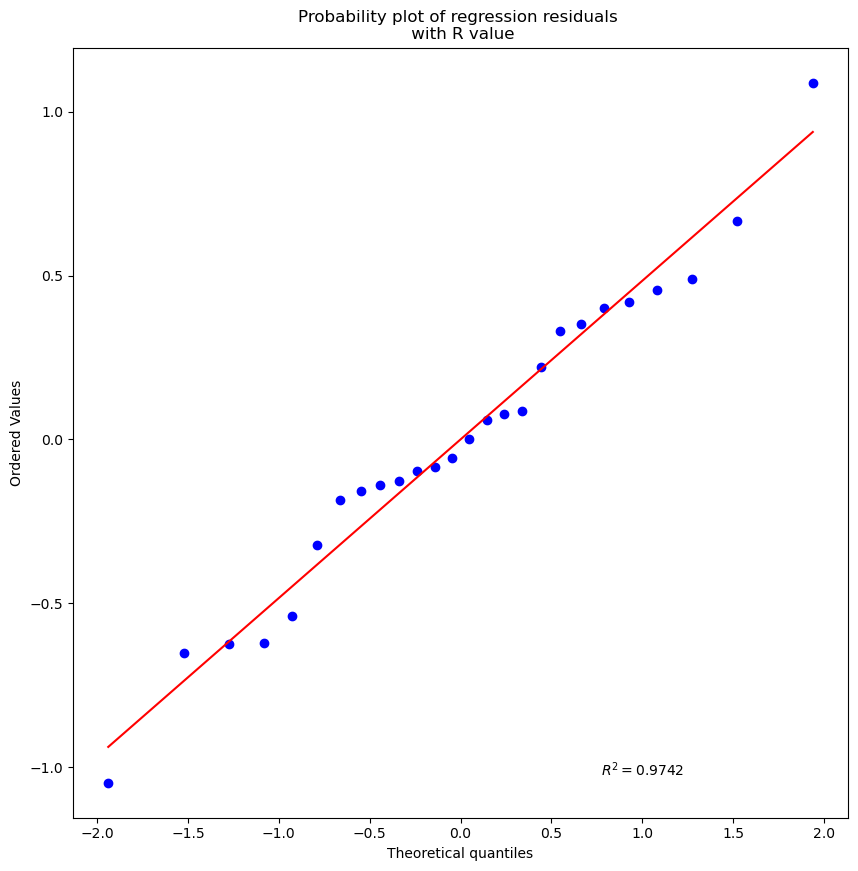

In [45]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

plt.show()

In [10]:
def plot_boxplot_with_mean_median(df, cat_col, cont_col):
    plt.figure(figsize=(10, 6))
    box_plot = sns.boxplot(
        x=cat_col, y=cont_col, data=df, showmeans=True,
        boxprops=dict(facecolor="lightblue", color="lightblue"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        flierprops=dict(markerfacecolor="black", markeredgecolor="black"),
        medianprops={"color": "darkblue", "linewidth": 2},
        meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"}
    )

    # Add legend
    handles = [
        plt.Line2D([0], [0], color='darkblue', lw=2, label='Median'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Mean')
    ]
    box_plot.legend(handles=handles, loc='lower right')

    plt.xlabel(cat_col.replace('_', ' ').title())
    plt.ylabel(cont_col.replace('_', ' ').title())
    plt.title(f'Box Plot of {cont_col.replace("_", " ").title()} by {cat_col.replace("_", " ").title()}')
    plt.xticks(rotation=45)
    plt.ylim(1, 5)
    plt.show()

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


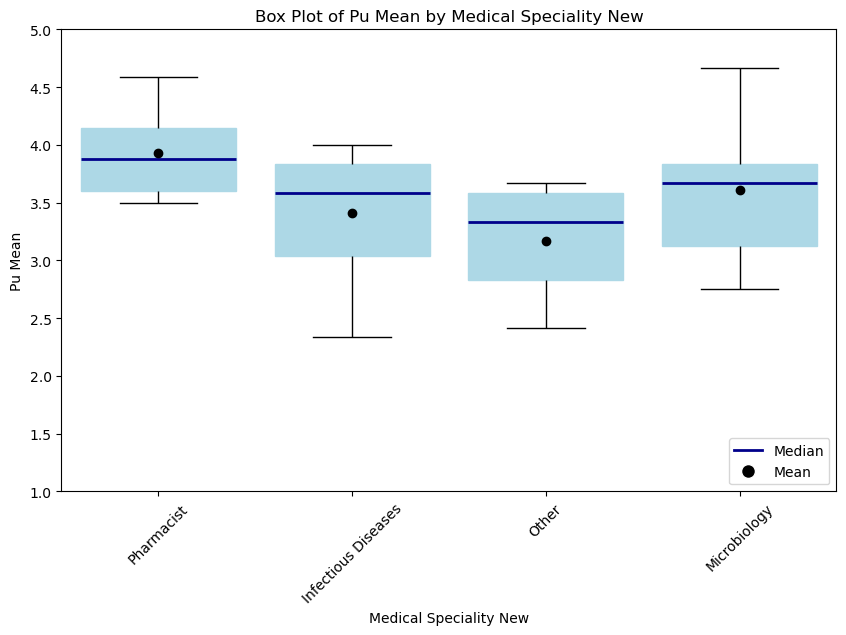

In [34]:
plot_boxplot_with_mean_median(combined_pu_df, 'medical_speciality_new', 'pu_mean')

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


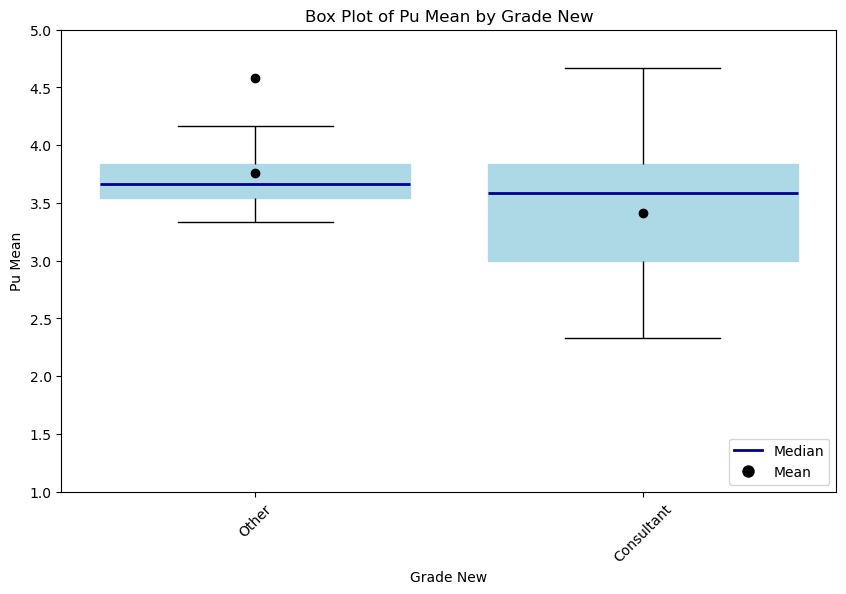

In [37]:
plot_boxplot_with_mean_median(combined_pu_df, 'grade_new', 'pu_mean')

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


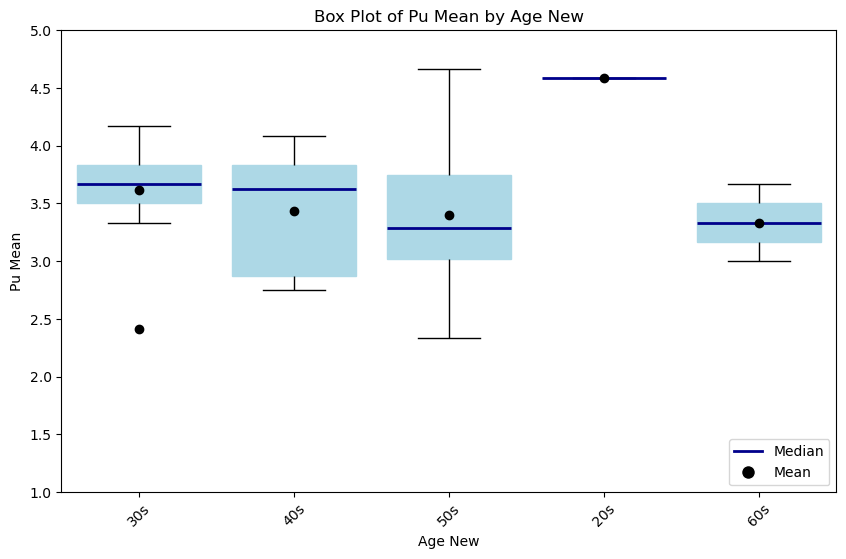

In [38]:
plot_boxplot_with_mean_median(combined_pu_df, 'age_new', 'pu_mean')

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


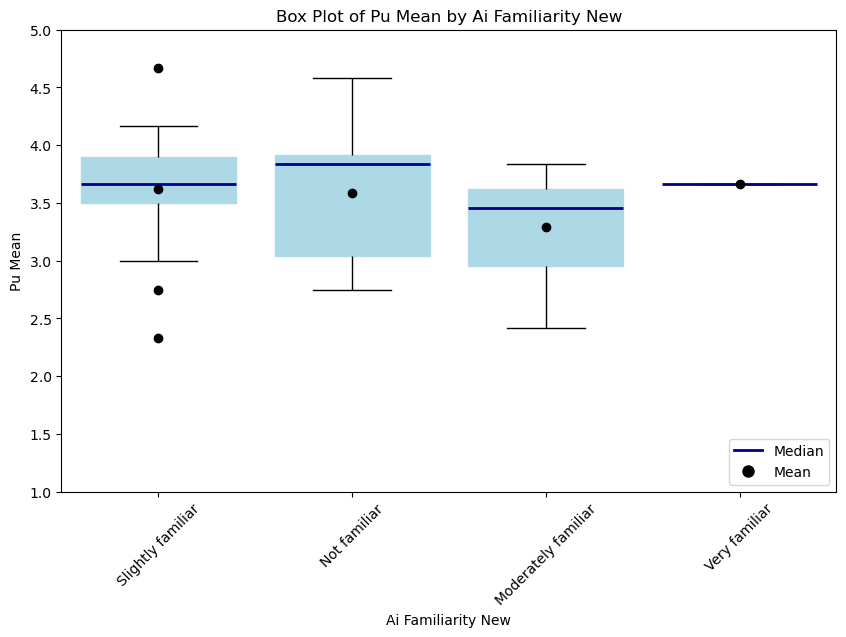

In [39]:
plot_boxplot_with_mean_median(combined_pu_df, 'ai_familiarity_new', 'pu_mean')

# Functions

In [11]:
def anover_kw_test(df, column):
    # Test for normality
    model = smf.ols(f"{column} ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=df).fit()
    shapiro_stat, shapiro_p_value = stats.shapiro(model.resid)
    print(f"Shapiro test: W-statistic={shapiro_stat}, p-value={shapiro_p_value}")
    stats.normaltest(model.resid)
    stats.kstest(model.resid, 'norm')

    # Test for vairance
    # Levene's Test for user_archetype
    levene_archetype_stat, levene_archetype_p_value = stats.levene(df[column][df['user_archetype'] == 'a'],
                        df[column][df['user_archetype'] == 'b'])
    print(f"Levene's test for user_archetype: W-statistic={levene_archetype_stat}, p-value={levene_archetype_p_value}")
    # Levene's Test for age_new
    unique_ages = df['age_new'].unique()
    grouped_ages = [df[column][df['age_new'] == age] for age in unique_ages]
    levene_age_stat, levene_age_p_value = stats.levene(*grouped_ages)
    print(f"Levene's test for age_new: W-statistic={levene_age_stat}, p-value={levene_age_p_value}")
    # Levene's Test for sex_new
    levene_sex_stat, levene_sex_p_value = stats.levene(df[column][df['sex_new'] == 'Male'],
                        df[column][df['sex_new'] == 'Female'])
    print(f"Levene's test for sex_new: W-statistic={levene_sex_stat}, p-value={levene_sex_p_value}")
    # Levene's Test for medical_speciality_new
    unique_medical_specialities = df['medical_speciality_new'].unique()
    grouped_medical_specialities = [df[column][df['medical_speciality_new'] == speciality] for speciality in unique_medical_specialities]
    levene_speciality_stat, levene_speciality_p_value = stats.levene(*grouped_medical_specialities)
    print(f"Levene's test for medical_speciality_new: W-statistic={levene_speciality_stat}, p-value={levene_speciality_p_value}")
    # Levene's Test for grade_new
    unique_grades = df['grade_new'].unique()
    grouped_grades = [df[column][df['grade_new'] == grade] for grade in unique_grades]
    levene_grade_stat, levene_grade_p_value = stats.levene(*grouped_grades)
    print(f"Levene's test for grade_new: W-statistic={levene_grade_stat}, p-value={levene_grade_p_value}")
    # Levene's Test for ai_familiarity_new
    unique_ais = df['ai_familiarity_new'].unique()
    grouped_ais = [df[column][df['ai_familiarity_new'] == ai] for ai in unique_ais]
    levene_ai_stat, levene_ai_p_value = stats.levene(*grouped_ais)
    print(f"Levene's test for ai_familiarity_new: W-statistic={levene_ai_stat}, p-value={levene_ai_p_value}")

    if shapiro_p_value >= 0.05 and levene_archetype_p_value >=0.05 and levene_age_p_value >=0.05 and levene_sex_p_value >= 0.05 and levene_speciality_p_value >=0.05 and levene_grade_p_value >= 0.05 and levene_ai_p_value >= 0.05:
        anova_bool = True
    else:
        anova_bool = False

    print('\n')
    print('anova_bool:', anova_bool)
    print('\n')

    # Perform the appropriate test
    # Do anover independantly for each variable and collectivly 
    if anova_bool:
        print('Collective')
        model = ols(f"{column} ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=df).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)
        # Interpretation
        for index, row in aov_table.iterrows():
            sum_sq, df_value, f_value, pr_f = row
            if pr_f < 0.05:
                print(f"ANOVA for {index}: Statistic={f_value:.4f}, p-value={pr_f:.4f}")
                print(f"  -> The differences in {index} are statistically significant.\n")
            #else:
            #    print(f"  -> The differences in {index} are ***NOT*** statistically significant.\n")

    # Function to perform ANOVA
    def perform_anova(df, group_var):
        groups = df.groupby(group_var)[column].apply(list)
        stat, p_value = f_oneway(*groups)
        return stat, p_value

    # Function to perform Kruskal-Wallis H test
    def perform_kruskal(df, group_var):
        groups = df.groupby(group_var)[column].apply(list)
        stat, p_value = kruskal(*groups)
        return stat, p_value

    print('\nIndependant')
    independent_vars = ['user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']
    results = {}
    for var in independent_vars:
        if anova_bool:
            stat, p_value = perform_anova(df, var)
            test_name = 'ANOVA'
        else:
            stat, p_value = perform_kruskal(df, var)
            test_name = 'Kruskal-Wallis'
        results[var] = {'test': test_name, 'statistic': stat, 'p_value': p_value}

    # Print the results
    for var, result in results.items():
        if result['p_value'] < 0.05:
            print(f"{result['test']} for {var}: Statistic={result['statistic']:.4f}, p-value={result['p_value']:.4f}")
            print(f"  -> The differences in {var} are statistically significant.\n")
        #else:
        #    print(f"  -> The differences in {var} are ***NOT*** statistically significant.\n")

In [12]:
def bar_plot(df, cat_col, question='TBC'):
    # Define the mapping of numbers to labels
    labels = {1: 'Strongly disagree', 2: 'Disagree', 3: 'Neither agree nor disagree', 4: 'Agree', 5: 'Strongly agree'}

    # Map the data to the labels
    data_labels = df[cat_col].map(labels)

    # Count the occurrences of each label and convert to percentages
    label_counts = data_labels.value_counts(normalize=True).reindex(labels.values(), fill_value=0) * 100

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    bars = label_counts.plot(kind='bar', color='skyblue')
    plt.ylabel('Percentage of respondents')
    if question != 'TBC':
        plt.title(question)
    plt.xticks(rotation=45)
    plt.ylim(0, 100)  # Set the y-axis limit to 0-100%

    # Annotate bars with percentage values
    for bar in bars.patches:
        height = bar.get_height()
        plt.annotate(f'{height:.0f}%', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords='offset points',
                     ha='center', va='bottom')

    plt.show()

In [69]:
def bar_plot_difference(df, cat_col, color_col, question='TBC'):
    # Define the mapping of numbers to labels
    labels = {1: 'Strongly disagree', 2: 'Disagree', 3: 'Neither agree nor disagree', 4: 'Agree', 5: 'Strongly agree'}
    
    # Map the data to the labels
    df['label'] = df[cat_col].map(labels)
    
    # Calculate total counts for overall percentage annotation
    total_counts = df['label'].value_counts(normalize=True).reindex(labels.values(), fill_value=0) * 100
    
    # Initialize an empty DataFrame for stacking
    stacked_data = pd.DataFrame(index=labels.values())

    # Populate the stacked_data DataFrame
    for category in df[color_col].unique():
        subset = df[df[color_col] == category]
        label_counts = subset['label'].value_counts().reindex(labels.values(), fill_value=0)
        stacked_data[category] = label_counts

    # Convert the stacked data into percentages of the total rows
    stacked_data = (stacked_data / len(df)) * 100

    # Define colors for the bars
    colors = ['skyblue', 'cornflowerblue', 'lightcoral', 'olivedrab', 'slategrey']

    # Plot the stacked bar chart
    plt.figure(figsize=(10, 6))
    bottom = None
    bar_width = 0.5  # Set the bar width to be narrower

    for i, category in enumerate(stacked_data.columns):
        bars = plt.bar(stacked_data.index, stacked_data[category], bottom=bottom, 
                       color=colors[i % len(colors)], alpha=0.7, width=bar_width, label=category)
        bottom = stacked_data[category] if bottom is None else bottom + stacked_data[category]

    # Annotate bars with individual segment percentage values
    for i, bar in enumerate(plt.gca().patches):
        height = bar.get_height()
        if height > 0:  # Only annotate if there is a visible bar
            plt.annotate(f'{height:.0f}%', 
                         xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                         xytext=(0, 0),  # Center the text on the bar
                         textcoords='offset points',
                         ha='center', va='center')

    # Annotate bars with overall percentage values
    overall_bars = plt.bar(stacked_data.index, total_counts, width=bar_width, color='none', edgecolor='none')
    for bar in overall_bars:
        height = bar.get_height()
        if height > 0:  # Only annotate if there is a visible bar
            plt.annotate(f'{height:.0f}%', 
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords='offset points',
                         ha='center', va='bottom')

    # Set labels and title
    plt.ylabel('Percentage of respondents')
    if question != 'TBC':
        plt.title(question)
    plt.xticks(rotation=45)
    plt.ylim(0, 100)  # Set the y-axis limit to 0-100%
    
    # Add legend
    plt.legend(title=color_col)
    
    plt.show()

# Example usage

In [13]:
# Create df
updated_tam_df = tam_df.copy()
# Imputation with Mode for categorical columns
updated_tam_df['age_new'].fillna(updated_tam_df['age_new'].mode()[0], inplace=True)
updated_tam_df['sex_new'].fillna(updated_tam_df['sex_new'].mode()[0], inplace=True)
updated_tam_df['medical_speciality_new'].fillna(updated_tam_df['medical_speciality_new'].mode()[0], inplace=True)
updated_tam_df['grade_new'].fillna(updated_tam_df['grade_new'].mode()[0], inplace=True)
updated_tam_df['ai_familiarity_new'].fillna(updated_tam_df['ai_familiarity_new'].mode()[0], inplace=True)

In [14]:
updated_tam_df.columns

Index(['user_id', 'user_archetype', 'ai_attitude', 'PU1', 'PU2', 'PU3', 'PU4',
       'PU5', 'PU6', 'PU7', 'PU8', 'PEOU1', 'PU9', 'PEOU2', 'SE1', 'SE2',
       'voluntary', 'SN1', 'SN2', 'prestige_image', 'PU10', 'PU11', 'BC1',
       'BC2', 'BC3', 'clinical_workflow', 'infrastructure', 'intention',
       'colleagues', 'PU12', 'final_comments', 'age_new', 'sex_new',
       'medical_speciality_new', 'grade_new', 'ai_familiarity_new'],
      dtype='object')

# PEOU

In [15]:
# PU
peou_df = tam_df_results.filter(regex='PEOU')
# Mean and std
peou_df.mean().mean()
peou_df.std().mean()

3.8170731707317076

0.7674523098395756

In [16]:
# Create df for demographic analysis
combined_peou_df = pd.DataFrame(peou_df.mean(axis=1), columns=['peou_mean']).join(tam_df['user_id'])
combined_peou_df = combined_peou_df.merge(demographics[['user_id', 'user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])


# Imputation with Mode for categorical columns
combined_peou_df['age_new'].fillna(combined_peou_df['age_new'].mode()[0], inplace=True)
combined_peou_df['sex_new'].fillna(combined_peou_df['sex_new'].mode()[0], inplace=True)
combined_peou_df['medical_speciality_new'].fillna(combined_peou_df['medical_speciality_new'].mode()[0], inplace=True)
combined_peou_df['grade_new'].fillna(combined_peou_df['grade_new'].mode()[0], inplace=True)
combined_peou_df['ai_familiarity_new'].fillna(combined_peou_df['ai_familiarity_new'].mode()[0], inplace=True)

# Drop
combined_peou_df.drop(columns='user_id', inplace=True)

In [17]:
anover_kw_test(combined_peou_df, 'peou_mean')

Shapiro test: W-statistic=0.9914398789405823, p-value=0.9875748157501221
Levene's test for user_archetype: W-statistic=0.00024087604765639787, p-value=0.9876963107525599
Levene's test for age_new: W-statistic=0.6761964562525753, p-value=0.6128901965599413
Levene's test for sex_new: W-statistic=1.941688373194411, p-value=0.17137636413309065
Levene's test for medical_speciality_new: W-statistic=2.976487759267494, p-value=0.04391176784552471
Levene's test for grade_new: W-statistic=0.023425216174530306, p-value=0.8791456529627275
Levene's test for ai_familiarity_new: W-statistic=1.1333857854707585, p-value=0.3481954374943478


anova_bool: False



Independant


# SE

In [18]:
# SE
se_df = tam_df_results.filter(regex='SE')
# Mean and std
se_df.mean().mean()
se_df.std().mean()

4.060975609756097

0.5211478134695632

In [75]:
# Create df for demographic analysis
combined_se_df = pd.DataFrame(se_df.mean(axis=1), columns=['se_mean']).join(tam_df['user_id'])
combined_se_df = combined_se_df.merge(demographics[['user_id', 'user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])


# Imputation with Mode for categorical columns
combined_se_df['age_new'].fillna(combined_se_df['age_new'].mode()[0], inplace=True)
combined_se_df['sex_new'].fillna(combined_se_df['sex_new'].mode()[0], inplace=True)
combined_se_df['medical_speciality_new'].fillna(combined_se_df['medical_speciality_new'].mode()[0], inplace=True)
combined_se_df['grade_new'].fillna(combined_se_df['grade_new'].mode()[0], inplace=True)
combined_se_df['ai_familiarity_new'].fillna(combined_se_df['ai_familiarity_new'].mode()[0], inplace=True)

# Drop
combined_se_df.drop(columns='user_id', inplace=True)

# Round for plot
combined_se_df['se_mean_round'] = combined_se_df['se_mean'].apply(lambda x: math.ceil(x))

In [76]:
anover_kw_test(combined_se_df, 'se_mean')

Shapiro test: W-statistic=0.9795975089073181, p-value=0.6602733731269836
Levene's test for user_archetype: W-statistic=0.01013933155517888, p-value=0.9203090613142871
Levene's test for age_new: W-statistic=1.3232566128478187, p-value=0.2799850277788168
Levene's test for sex_new: W-statistic=0.25879611879552916, p-value=0.6138144535231012
Levene's test for medical_speciality_new: W-statistic=0.42113821138211377, p-value=0.7389203701195282
Levene's test for grade_new: W-statistic=0.5778436289035787, p-value=0.45172996876930005
Levene's test for ai_familiarity_new: W-statistic=1.305957536054875, p-value=0.2870002943691107


anova_bool: True


Collective
ANOVA for ai_familiarity_new: Statistic=3.1255, p-value=0.0422
  -> The differences in ai_familiarity_new are statistically significant.


Independant


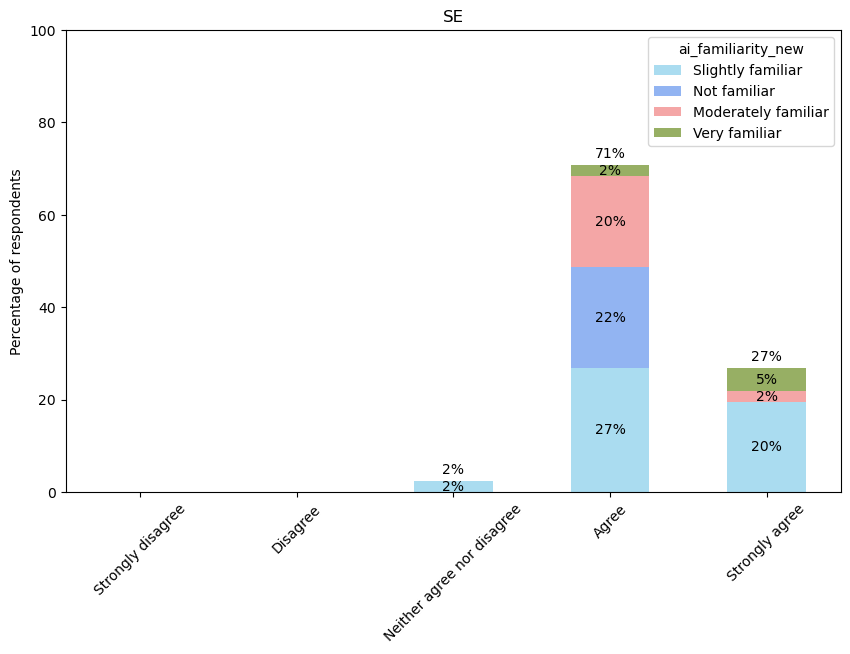

In [78]:
bar_plot_difference(combined_se_df, 'se_mean_round', 'ai_familiarity_new', 'SE')

4.024390243902439

0.41760057938470224

Shapiro test: W-statistic=0.9391762018203735, p-value=0.02945023961365223
Levene's test for user_archetype: W-statistic=0.11308203991130818, p-value=0.73846487673602
Levene's test for age_new: W-statistic=1.6258784621744522, p-value=0.18893637319530227
Levene's test for sex_new: W-statistic=0.5800510876730388, p-value=0.4508735086562127
Levene's test for medical_speciality_new: W-statistic=1.1305181410023053, p-value=0.34930967398613527
Levene's test for grade_new: W-statistic=0.22354292401209228, p-value=0.6389889790535435
Levene's test for ai_familiarity_new: W-statistic=1.1607287277061251, p-value=0.3377374380228977


anova_bool: False



Independant


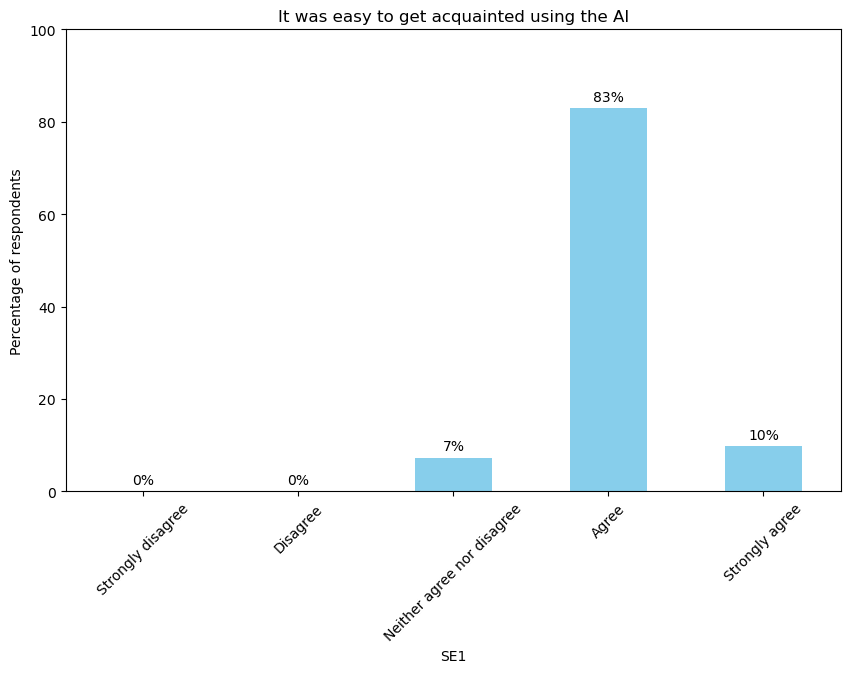

In [21]:
updated_tam_df['SE1'].mean()
updated_tam_df['SE1'].std()
anover_kw_test(updated_tam_df, 'SE1')
bar_plot(updated_tam_df, 'SE1', 'It was easy to get acquainted using the AI')

4.097560975609756

0.6246950475544241

Shapiro test: W-statistic=0.9630258083343506, p-value=0.20049035549163818
Levene's test for user_archetype: W-statistic=0.01486280487804885, p-value=0.9035938650931294
Levene's test for age_new: W-statistic=1.098963609444401, p-value=0.37195543587974456
Levene's test for sex_new: W-statistic=1.692831624777111, p-value=0.20086280959114103
Levene's test for medical_speciality_new: W-statistic=0.8158215753883474, p-value=0.4933706556432691
Levene's test for grade_new: W-statistic=2.0371249730196412, p-value=0.16145772758357743
Levene's test for ai_familiarity_new: W-statistic=0.45714102810319446, p-value=0.7138631201409494


anova_bool: True


Collective

Independant


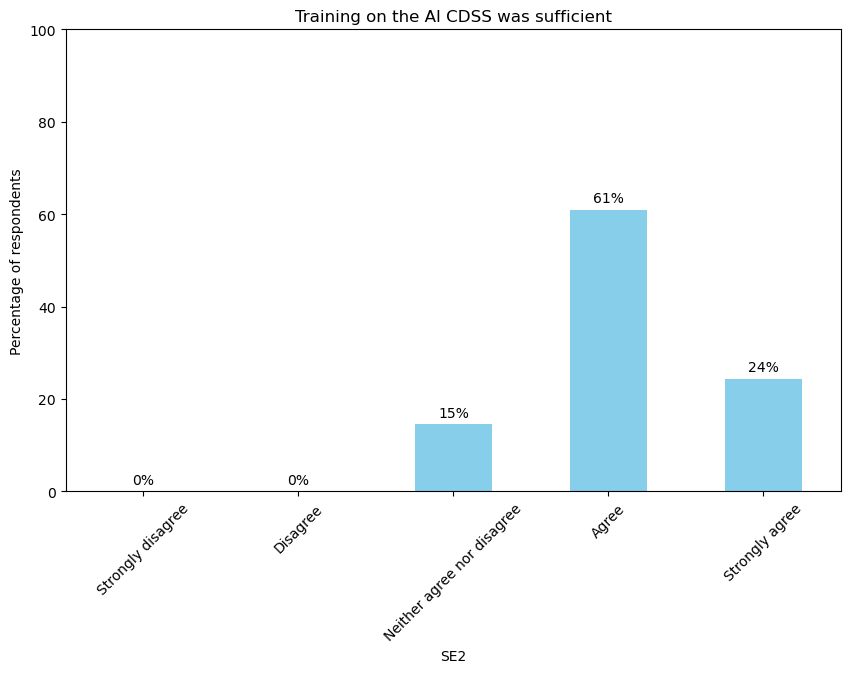

In [22]:
updated_tam_df['SE2'].mean()
updated_tam_df['SE2'].std()
anover_kw_test(updated_tam_df, 'SE2')
bar_plot(updated_tam_df, 'SE2', 'Training on the AI CDSS was sufficient')

# SN

In [23]:
# SE
sn_df = tam_df_results.filter(regex='SN')
# Mean and std
sn_df.mean().mean()
sn_df.std().mean()

3.1951219512195124

0.6134439264393536

3.268292682926829

0.5488346856705776

Shapiro test: W-statistic=0.9418908953666687, p-value=0.03650983050465584
Levene's test for user_archetype: W-statistic=0.040849917701630996, p-value=0.8408785260365169
Levene's test for age_new: W-statistic=0.2994401184117382, p-value=0.8763727568016588
Levene's test for sex_new: W-statistic=0.030439024390243825, p-value=0.8624003680371203
Levene's test for medical_speciality_new: W-statistic=0.24909153073666962, p-value=0.86145668808053
Levene's test for grade_new: W-statistic=0.2166679192271894, p-value=0.6441795667185477
Levene's test for ai_familiarity_new: W-statistic=0.12116294963877955, p-value=0.9470634585318862


anova_bool: False



Independant


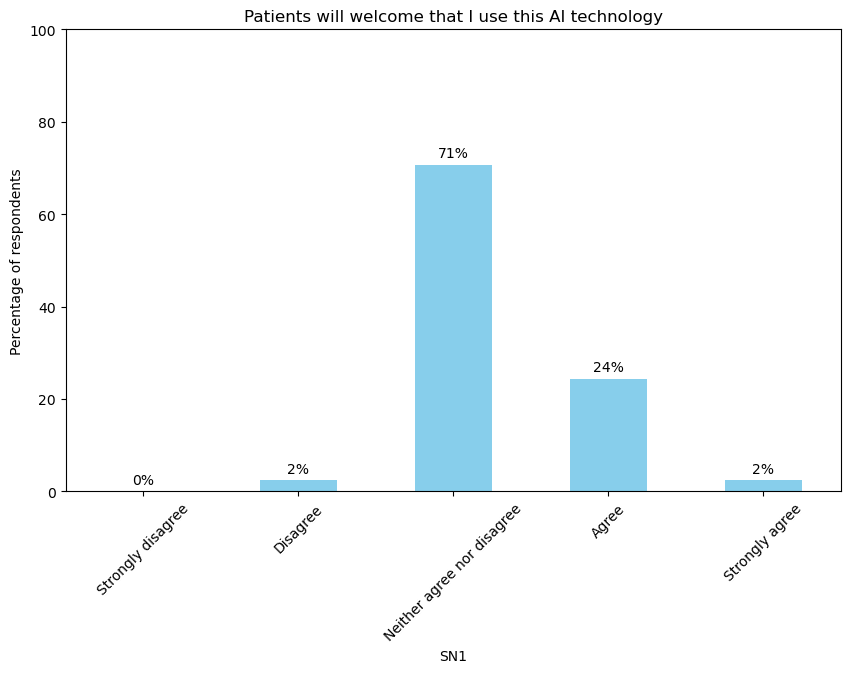

In [24]:
updated_tam_df['SN1'].mean()
updated_tam_df['SN1'].std()
anover_kw_test(updated_tam_df, 'SN1')
bar_plot(updated_tam_df, 'SN1', 'Patients will welcome that I use this AI technology')

3.1219512195121952

0.6780531672081295

Shapiro test: W-statistic=0.9802792072296143, p-value=0.6861021518707275
Levene's test for user_archetype: W-statistic=6.910172516359311, p-value=0.012197364031522336
Levene's test for age_new: W-statistic=0.8938536585365856, p-value=0.47765460315786423
Levene's test for sex_new: W-statistic=0.704607046070461, p-value=0.4063561656139624
Levene's test for medical_speciality_new: W-statistic=0.5898294277060417, p-value=0.6255485646185741
Levene's test for grade_new: W-statistic=0.5169671261930013, p-value=0.47642456214464524
Levene's test for ai_familiarity_new: W-statistic=0.5867342831844161, p-value=0.6275254732043363


anova_bool: False



Independant


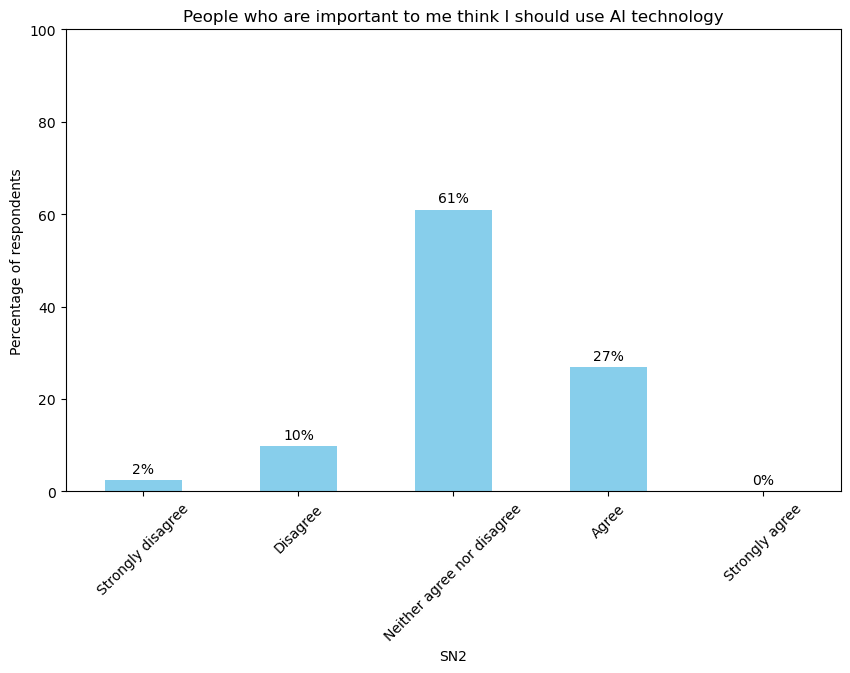

In [25]:
updated_tam_df['SN2'].mean()
updated_tam_df['SN2'].std()
anover_kw_test(updated_tam_df, 'SN2')
bar_plot(updated_tam_df, 'SN2', 'People who are important to me think I should use AI technology')

# BC

In [26]:
# BC
bc_df = tam_df_results.filter(regex='BC')
# Mean and std
bc_df.mean().mean()
bc_df.std().mean()

3.4433285509325686

0.878544698559638

2.682926829268293

0.8786075457860556

Shapiro test: W-statistic=0.9715161323547363, p-value=0.38589203357696533
Levene's test for user_archetype: W-statistic=0.41018375258592193, p-value=0.5256216162460418
Levene's test for age_new: W-statistic=0.7589371735713201, p-value=0.558856811855363
Levene's test for sex_new: W-statistic=0.9293955539777422, p-value=0.3409600236673702
Levene's test for medical_speciality_new: W-statistic=0.2640705800493817, p-value=0.850828472760304
Levene's test for grade_new: W-statistic=0.03790663062296868, p-value=0.8466414507689111
Levene's test for ai_familiarity_new: W-statistic=0.27871246059399374, p-value=0.8403920625611804


anova_bool: True


Collective
ANOVA for grade_new: Statistic=4.6332, p-value=0.0405
  -> The differences in grade_new are statistically significant.


Independant


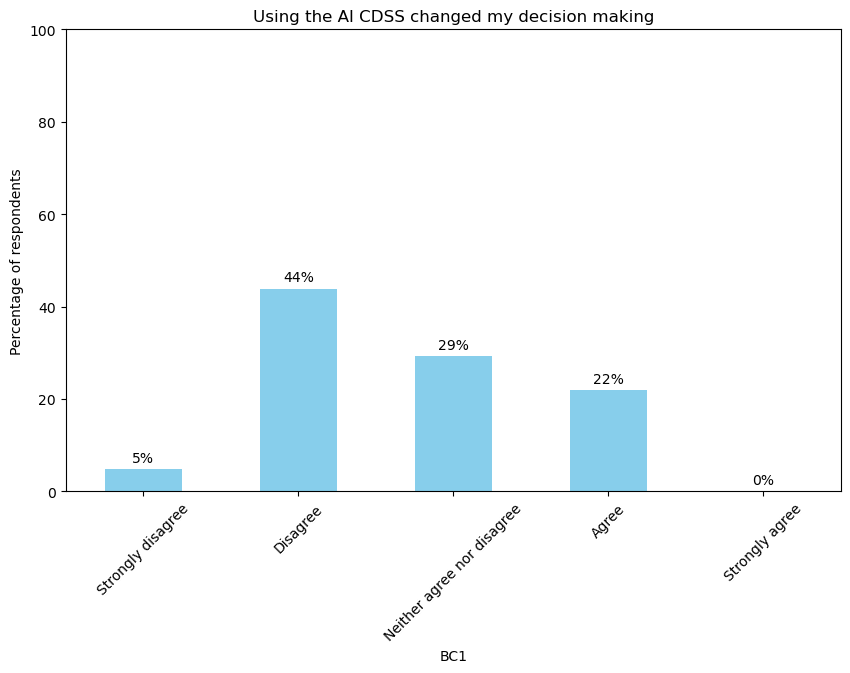

In [27]:
updated_tam_df['BC1'].mean()
updated_tam_df['BC1'].std()
anover_kw_test(updated_tam_df, 'BC1')
bar_plot(updated_tam_df, 'BC1', 'Using the AI CDSS changed my decision making')

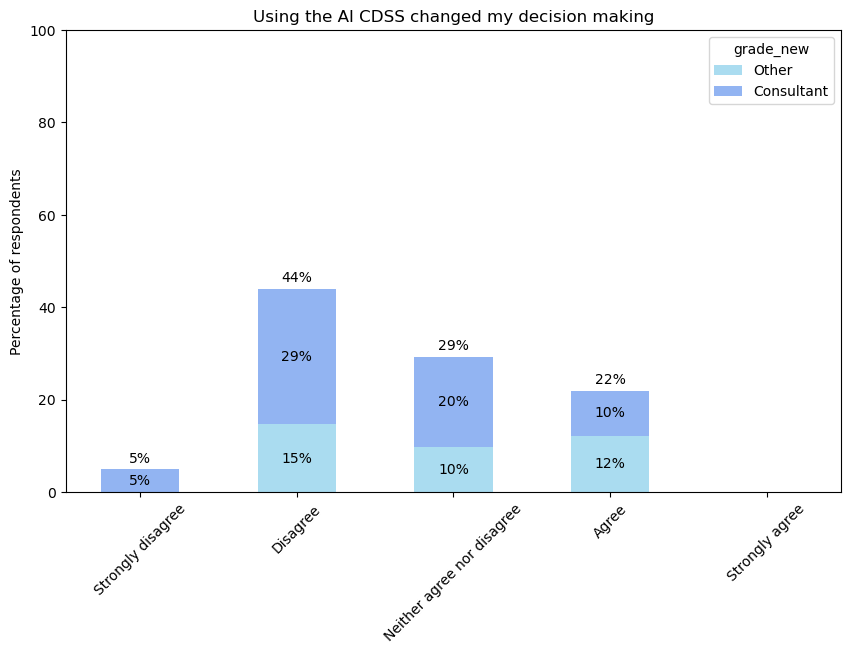

In [56]:
bar_plot_difference(updated_tam_df, 'BC1', 'grade_new', 'Using the AI CDSS changed my decision making')

In [43]:
updated_tam_df.grade_new.value_counts()

grade_new
Consultant    26
Other         15
Name: count, dtype: int64

In [46]:
updated_tam_df.columns

Index(['user_id', 'user_archetype', 'ai_attitude', 'PU1', 'PU2', 'PU3', 'PU4',
       'PU5', 'PU6', 'PU7', 'PU8', 'PEOU1', 'PU9', 'PEOU2', 'SE1', 'SE2',
       'voluntary', 'SN1', 'SN2', 'prestige_image', 'PU10', 'PU11', 'BC1',
       'BC2', 'BC3', 'clinical_workflow', 'infrastructure', 'intention',
       'colleagues', 'PU12', 'final_comments', 'age_new', 'sex_new',
       'medical_speciality_new', 'grade_new', 'ai_familiarity_new',
       'ai_familiarity'],
      dtype='object')

3.9411764705882355

0.885614885540095

Shapiro test: W-statistic=0.9766207337379456, p-value=0.6637964844703674
Levene's test for user_archetype: W-statistic=nan, p-value=nan
Levene's test for age_new: W-statistic=nan, p-value=nan
Levene's test for sex_new: W-statistic=nan, p-value=nan
Levene's test for medical_speciality_new: W-statistic=nan, p-value=nan
Levene's test for grade_new: W-statistic=nan, p-value=nan
Levene's test for ai_familiarity_new: W-statistic=nan, p-value=nan


anova_bool: False



Independant


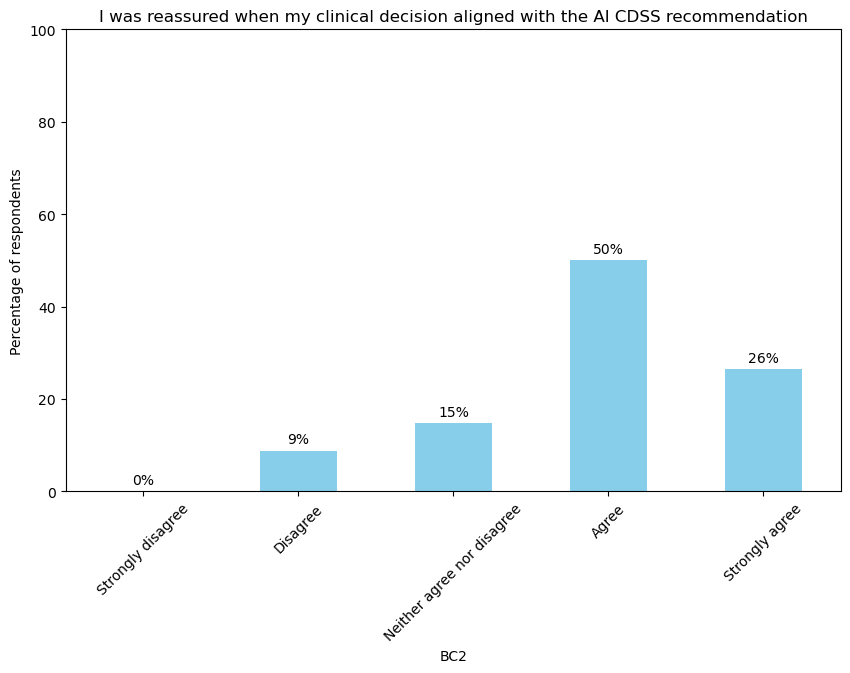

In [28]:
updated_tam_df['BC2'].mean()
updated_tam_df['BC2'].std()
anover_kw_test(updated_tam_df, 'BC2')
bar_plot(updated_tam_df, 'BC2', 'I was reassured when my clinical decision aligned with the AI CDSS recommendation')

3.7058823529411766

0.8714116643527634

Shapiro test: W-statistic=0.9573664665222168, p-value=0.2035387009382248
Levene's test for user_archetype: W-statistic=nan, p-value=nan
Levene's test for age_new: W-statistic=nan, p-value=nan
Levene's test for sex_new: W-statistic=nan, p-value=nan
Levene's test for medical_speciality_new: W-statistic=nan, p-value=nan
Levene's test for grade_new: W-statistic=nan, p-value=nan
Levene's test for ai_familiarity_new: W-statistic=nan, p-value=nan


anova_bool: False



Independant


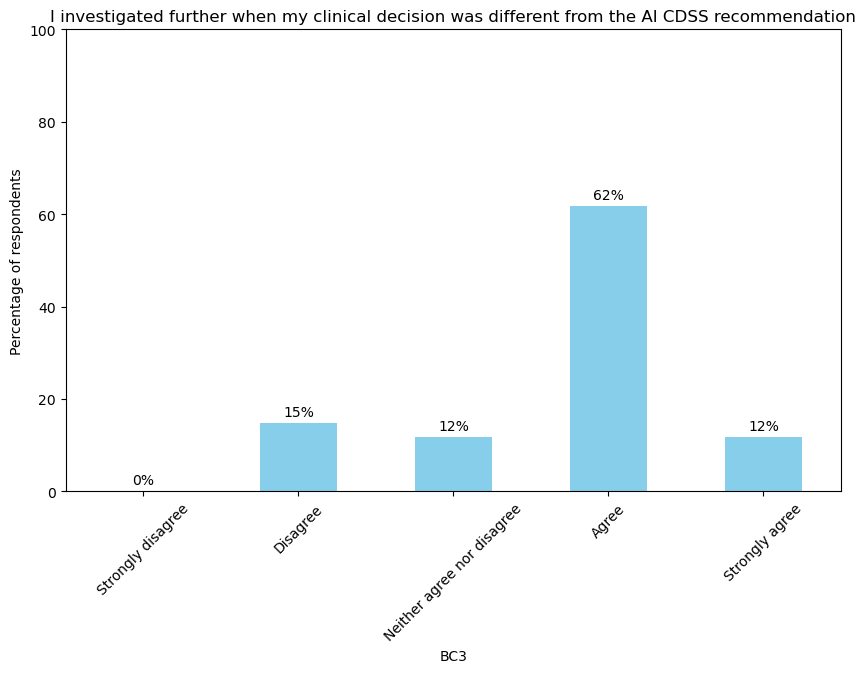

In [29]:
updated_tam_df['BC3'].mean()
updated_tam_df['BC3'].std()
anover_kw_test(updated_tam_df, 'BC3')
bar_plot(updated_tam_df, 'BC3', 'I investigated further when my clinical decision was different from the AI CDSS recommendation')

# Others

In [30]:
# ai_attitude
updated_tam_df['ai_attitude'].mean()
updated_tam_df['ai_attitude'].std()
anover_kw_test(updated_tam_df, 'ai_attitude')

3.5853658536585367

0.6699108058576737

Shapiro test: W-statistic=0.9391447305679321, p-value=0.029377155005931854
Levene's test for user_archetype: W-statistic=6.000295758818542, p-value=0.01889775029059881
Levene's test for age_new: W-statistic=0.3457416310148635, p-value=0.845214204388044
Levene's test for sex_new: W-statistic=0.10369956997012773, p-value=0.7491542028063605
Levene's test for medical_speciality_new: W-statistic=0.20014251935348037, p-value=0.8956177437591699
Levene's test for grade_new: W-statistic=0.9882800126702564, p-value=0.3262913720225903
Levene's test for ai_familiarity_new: W-statistic=0.794428984558302, p-value=0.5048299324054943


anova_bool: False



Independant


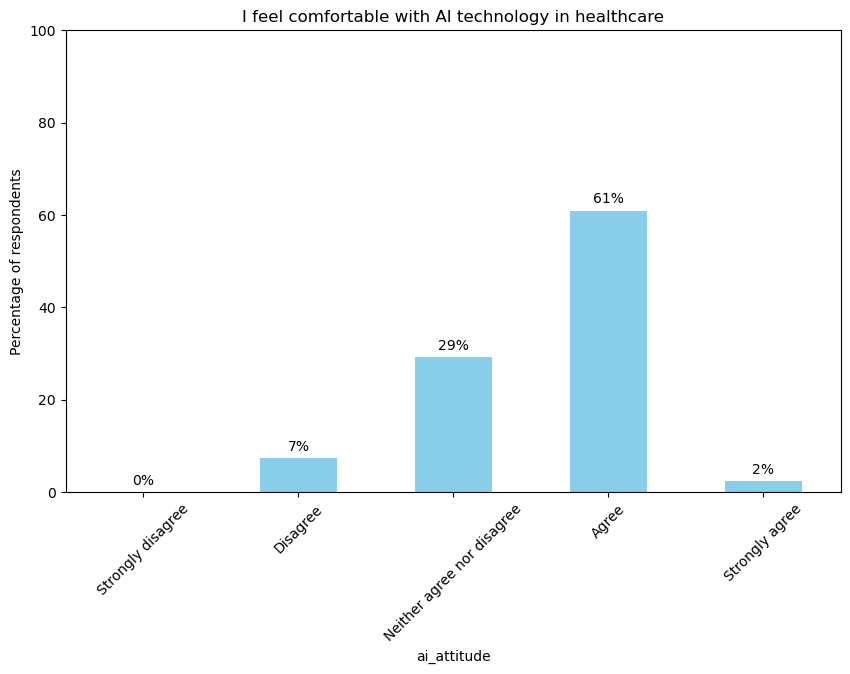

In [31]:
bar_plot(updated_tam_df, 'ai_attitude', 'I feel comfortable with AI technology in healthcare')

In [ ]:
Plot colour coded! - slight shift to right with non consultants 

In [34]:
updated_tam_df['grade_new'].value_counts()

grade_new
Consultant    26
Other         15
Name: count, dtype: int64

In [35]:
from scipy.stats import pearsonr, spearmanr
from scipy.stats import shapiro, levene

# Define the mapping of numbers to labels
labels = {'Not familiar': 1, 'Slightly familiar': 2, 'Moderately familiar': 3, 'Very familiar': 4, 'Extremely familiar': 5}

# Add new column 
updated_tam_df['ai_familiarity'] = updated_tam_df.ai_familiarity_new.map(labels)

# Shapiro-Wilk Test for normality
shapiro_familiarity_stat, shapiro_familiarity_p = shapiro(updated_tam_df['ai_familiarity'])
shapiro_comfort_stat, shapiro_comfort_p = shapiro(updated_tam_df['ai_attitude'])
print(f"Shapiro-Wilk test for familiarity_with_ai: Stat={shapiro_familiarity_stat}, p-value={shapiro_familiarity_p}")
print(f"Shapiro-Wilk test for comfort_with_ai: Stat={shapiro_comfort_stat}, p-value={shapiro_comfort_p}")

# Levene's Test for homogeneity of variances
levene_stat, levene_p = levene(updated_tam_df['ai_familiarity'], updated_tam_df['ai_attitude'])
print(f"Levene's test: Stat={levene_stat}, p-value={levene_p}")

# Pearson correlation
pearson_corr, pearson_p_value = pearsonr(updated_tam_df['ai_familiarity'], updated_tam_df['ai_attitude'])
print(f"Pearson correlation: {pearson_corr}, p-value: {pearson_p_value}")

# Spearman correlation
spearman_corr, spearman_p_value = spearmanr(updated_tam_df['ai_familiarity'], updated_tam_df['ai_attitude'])
print(f"Spearman correlation: {spearman_corr}, p-value: {spearman_p_value}")

Shapiro-Wilk test for familiarity_with_ai: Stat=0.8559691905975342, p-value=0.00010538018977968022
Shapiro-Wilk test for comfort_with_ai: Stat=0.7545380592346191, p-value=6.849546707599075e-07
Levene's test: Stat=0.7587253414264029, p-value=0.38633414564532487
Pearson correlation: 0.15254394262499632, p-value: 0.34102635137733395
Spearman correlation: 0.15149771160959002, p-value: 0.3443872719236032


Above ^^^ See not correlation between familiarity with AI and if comftable with AI indicating understanding AI is not driving force

4.365853658536586

0.4876524151983464

Shapiro test: W-statistic=0.938560962677002, p-value=0.028057124465703964
Levene's test for user_archetype: W-statistic=0.040279653610868375, p-value=0.8419777873052012
Levene's test for age_new: W-statistic=0.5112417573687138, p-value=0.7278052176153255
Levene's test for sex_new: W-statistic=2.917003940781767, p-value=0.09560010818193844
Levene's test for medical_speciality_new: W-statistic=1.472875697379075, p-value=0.2377424235430181
Levene's test for grade_new: W-statistic=0.10283454185893222, p-value=0.7501662669514114
Levene's test for ai_familiarity_new: W-statistic=0.9227010404819074, p-value=0.43939450785990875


anova_bool: False



Independant


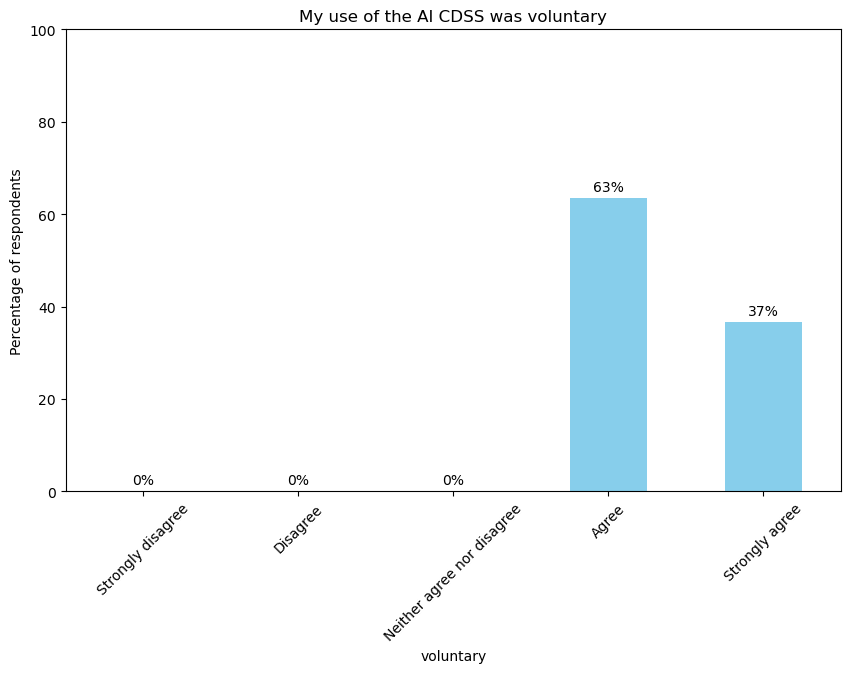

In [36]:
# voluntary
updated_tam_df['voluntary'].mean()
updated_tam_df['voluntary'].std()
anover_kw_test(updated_tam_df, 'voluntary')
bar_plot(updated_tam_df, 'voluntary', 'My use of the AI CDSS was voluntary')

3.5365853658536586

0.8688371819739805

Shapiro test: W-statistic=0.956394374370575, p-value=0.11750569194555283
Levene's test for user_archetype: W-statistic=0.23025285298724515, p-value=0.6340166954402273
Levene's test for age_new: W-statistic=0.43676137792305747, p-value=0.7811532997085575
Levene's test for sex_new: W-statistic=0.64505955757232, p-value=0.4267525120898795
Levene's test for medical_speciality_new: W-statistic=1.2787642276422766, p-value=0.2959095905054796
Levene's test for grade_new: W-statistic=0.0036964488815872886, p-value=0.9518302448851937
Levene's test for ai_familiarity_new: W-statistic=0.23543134382726083, p-value=0.8710916422283141


anova_bool: True


Collective

Independant


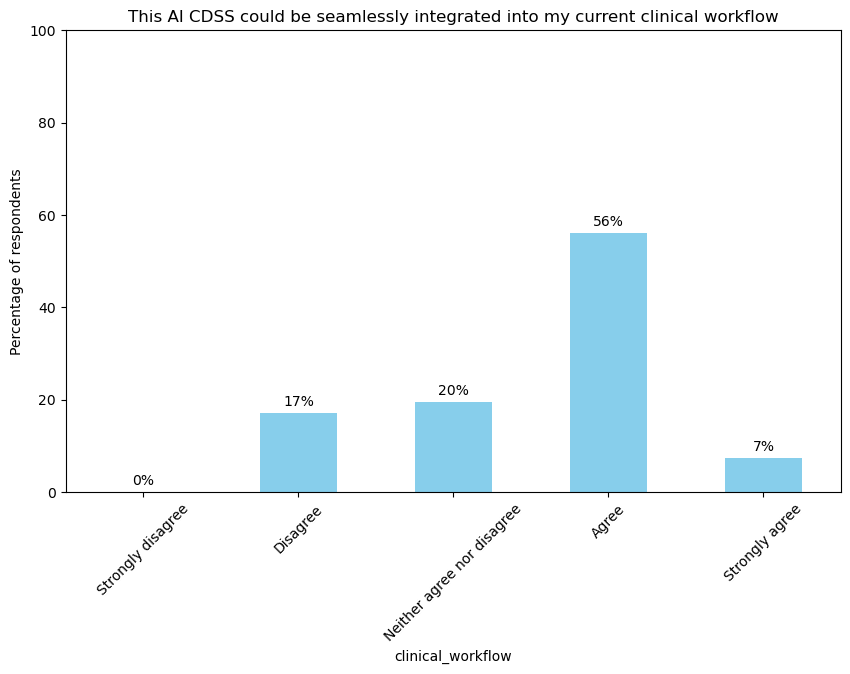

In [37]:
# clinical_workflow
updated_tam_df['clinical_workflow'].mean()
updated_tam_df['clinical_workflow'].std()
anover_kw_test(updated_tam_df, 'clinical_workflow')
bar_plot(updated_tam_df, 'clinical_workflow', 'This AI CDSS could be seamlessly integrated into my current clinical workflow')

2.7560975609756095

0.8596652780262221

Shapiro test: W-statistic=0.9790815114974976, p-value=0.6407895684242249
Levene's test for user_archetype: W-statistic=0.27720330729220594, p-value=0.6015219409271775
Levene's test for age_new: W-statistic=0.9667877529839128, p-value=0.43759725911487435
Levene's test for sex_new: W-statistic=2.9043840389480216, p-value=0.09629510152608065
Levene's test for medical_speciality_new: W-statistic=0.26120753370543104, p-value=0.8528642119314847
Levene's test for grade_new: W-statistic=1.6717445912000657, p-value=0.20363219230978857
Levene's test for ai_familiarity_new: W-statistic=0.31703142448626015, p-value=0.8129614492876716


anova_bool: True


Collective

Independant


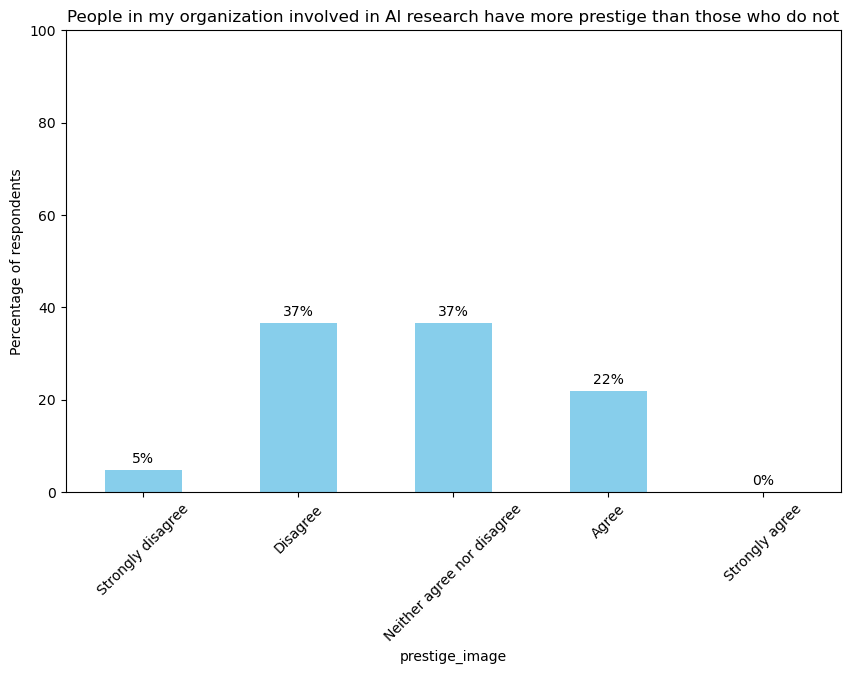

In [38]:
# prestige_image
updated_tam_df['prestige_image'].mean()
updated_tam_df['prestige_image'].std()
anover_kw_test(updated_tam_df, 'prestige_image')
bar_plot(updated_tam_df, 'prestige_image', 'People in my organization involved in AI research have more prestige than those who do not')

2.951219512195122

0.9734274372595815

Shapiro test: W-statistic=0.9845741391181946, p-value=0.8419515490531921
Levene's test for user_archetype: W-statistic=1.3746005821293041, p-value=0.24813506186543283
Levene's test for age_new: W-statistic=0.727674284616862, p-value=0.5789219344343768
Levene's test for sex_new: W-statistic=1.1679754698647584, p-value=0.28645555197677963
Levene's test for medical_speciality_new: W-statistic=0.07862365464164042, p-value=0.9711880930924387
Levene's test for grade_new: W-statistic=0.24468669123990308, p-value=0.6236166404564829
Levene's test for ai_familiarity_new: W-statistic=0.21911070962561482, p-value=0.8825099884115563


anova_bool: True


Collective
ANOVA for sex_new: Statistic=5.5443, p-value=0.0261
  -> The differences in sex_new are statistically significant.

ANOVA for medical_speciality_new: Statistic=5.7496, p-value=0.0036
  -> The differences in medical_speciality_new are statistically significant.


Independant


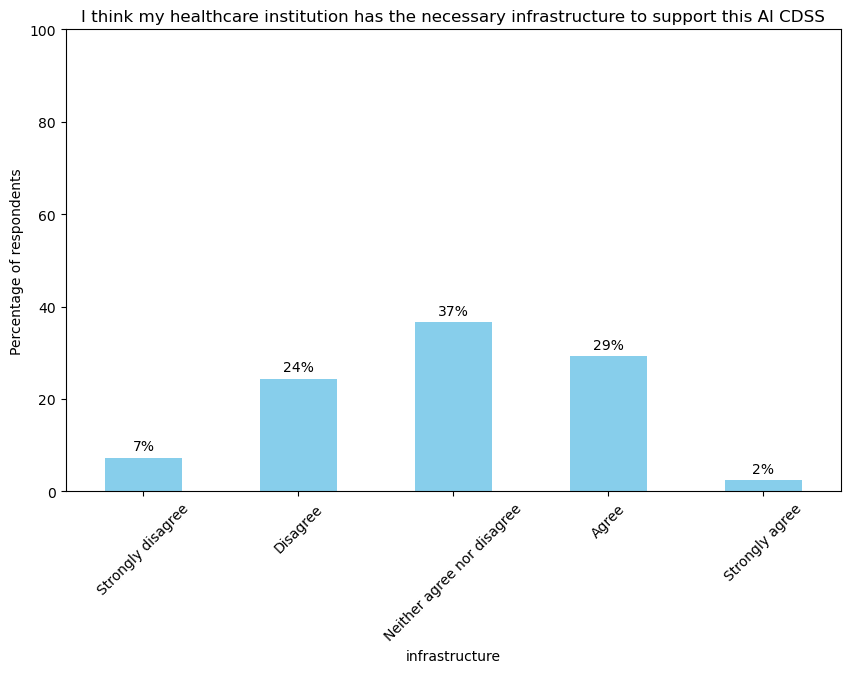

In [39]:
# infrastructure
updated_tam_df['infrastructure'].mean()
updated_tam_df['infrastructure'].std()
anover_kw_test(updated_tam_df, 'infrastructure')
bar_plot(updated_tam_df, 'infrastructure', 'I think my healthcare institution has the necessary infrastructure to support this AI CDSS')

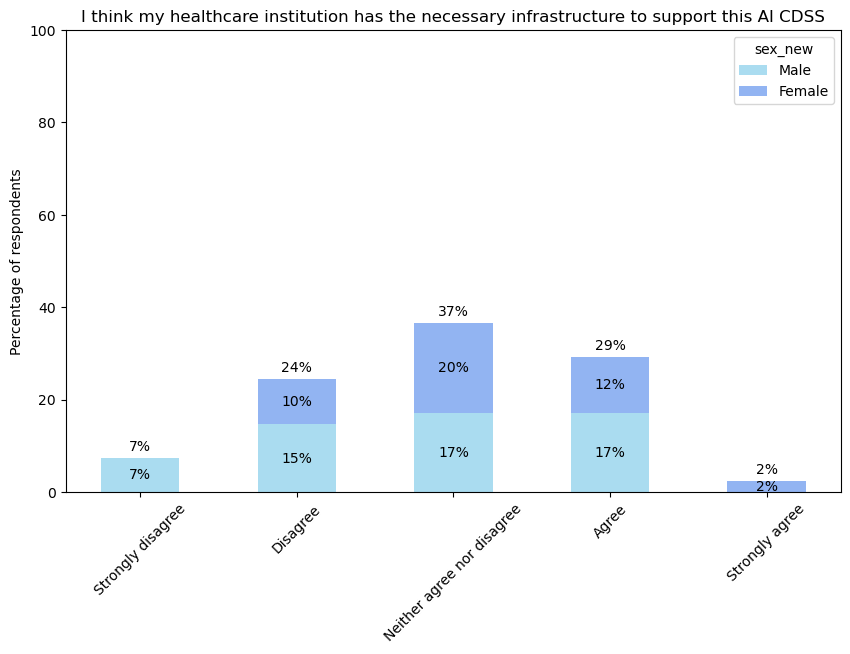

In [57]:
bar_plot_difference(updated_tam_df, 'infrastructure', 'sex_new', 'I think my healthcare institution has the necessary infrastructure to support this AI CDSS')

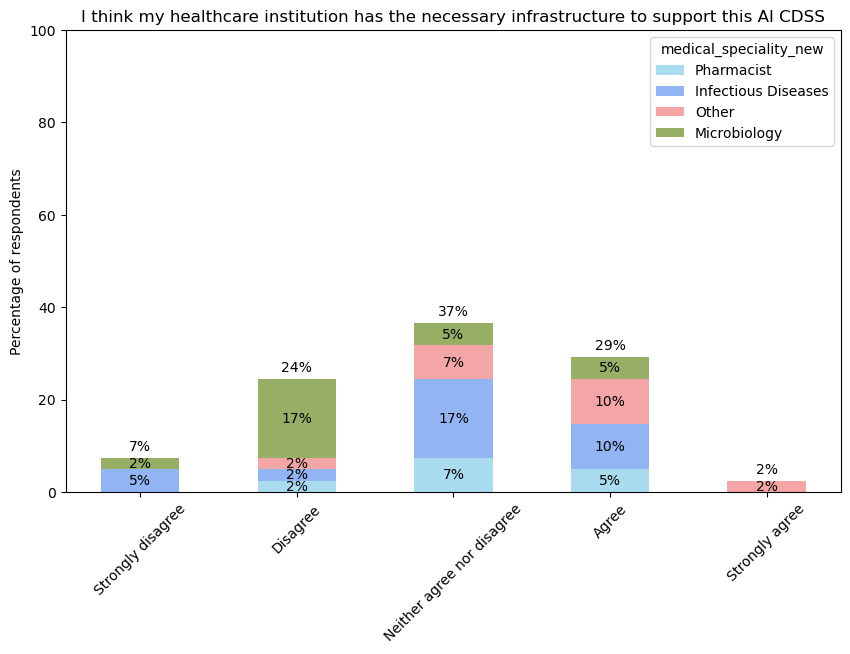

In [58]:
bar_plot_difference(updated_tam_df, 'infrastructure', 'medical_speciality_new', 'I think my healthcare institution has the necessary infrastructure to support this AI CDSS')

3.7804878048780486

0.6896446592974974

Shapiro test: W-statistic=0.9258507490158081, p-value=0.010542946867644787
Levene's test for user_archetype: W-statistic=0.11480235492010106, p-value=0.7365591711302069
Levene's test for age_new: W-statistic=0.46294011578248073, p-value=0.7624097834825585
Levene's test for sex_new: W-statistic=3.4868367156953997, p-value=0.06938791781730938
Levene's test for medical_speciality_new: W-statistic=0.2710856049736968, p-value=0.8458332090068397
Levene's test for grade_new: W-statistic=0.5939734527400651, p-value=0.44553075587132973
Levene's test for ai_familiarity_new: W-statistic=0.7905512591711285, p-value=0.5069307675807444


anova_bool: False



Independant


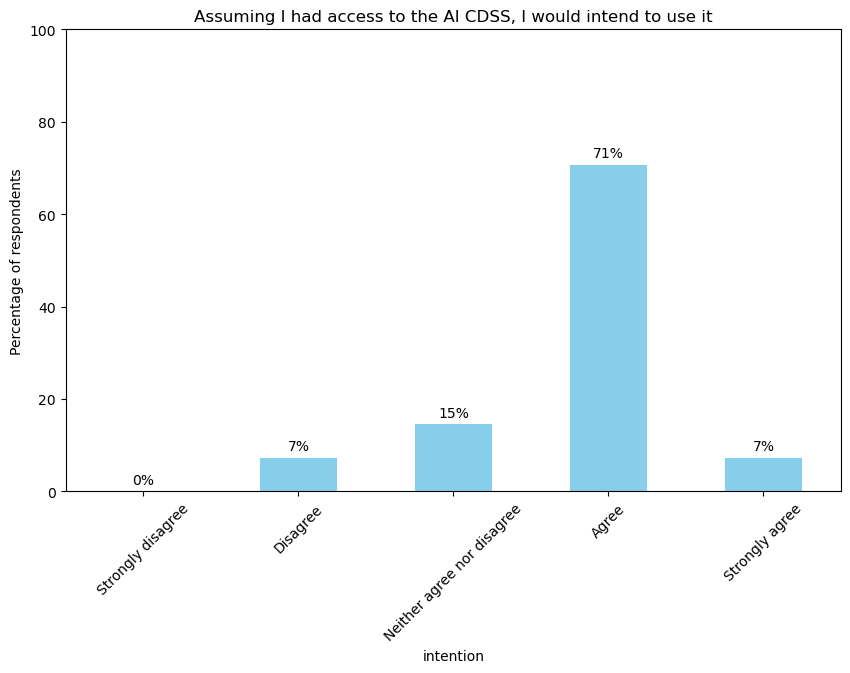

In [40]:
# intention
updated_tam_df['intention'].mean()
updated_tam_df['intention'].std()
anover_kw_test(updated_tam_df, 'intention')
bar_plot(updated_tam_df, 'intention', 'Assuming I had access to the AI CDSS, I would intend to use it')

3.073170731707317

0.6476976108663296

Shapiro test: W-statistic=0.981724739074707, p-value=0.7406259179115295
Levene's test for user_archetype: W-statistic=1.1480235492010096, p-value=0.29054925840808926
Levene's test for age_new: W-statistic=2.342486781511172, p-value=0.07333654353509311
Levene's test for sex_new: W-statistic=0.9384514650515636, p-value=0.33864605275500514
Levene's test for medical_speciality_new: W-statistic=0.8164924506387922, p-value=0.49301486103625625
Levene's test for grade_new: W-statistic=0.019863052458830813, p-value=0.8886456858852337
Levene's test for ai_familiarity_new: W-statistic=0.6617886178861787, p-value=0.5808210917593184


anova_bool: True


Collective

Independant


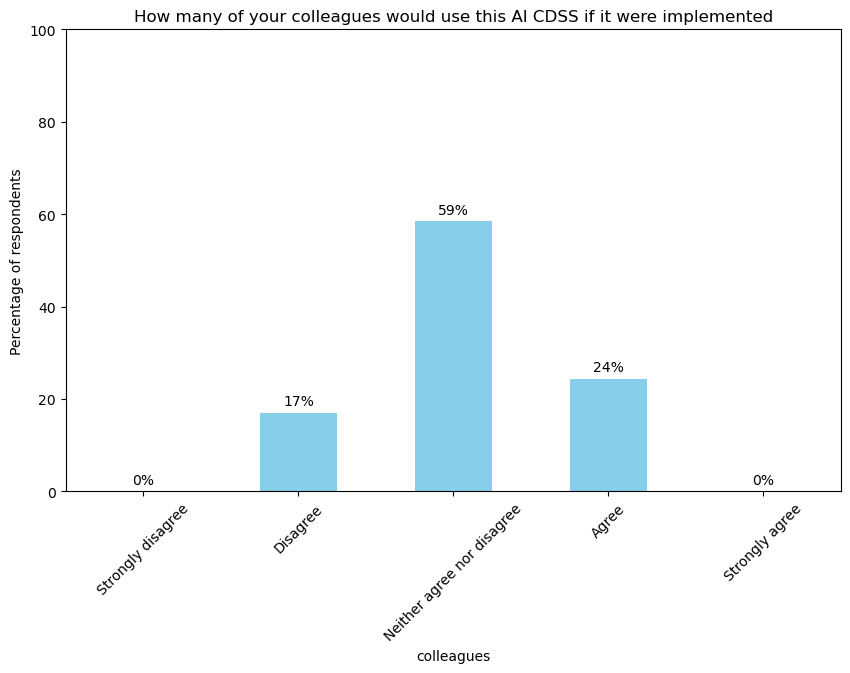

In [41]:
# prestige_image
updated_tam_df['colleagues'].mean()
updated_tam_df['colleagues'].std()
anover_kw_test(updated_tam_df, 'colleagues')
bar_plot(updated_tam_df, 'colleagues', 'How many of your colleagues would use this AI CDSS if it were implemented')

# Old

In [47]:
mardia_test = pg.multivariate_normality(pu_df, alpha=0.05)
print(mardia_test)

HZResults(hz=0.9957092836013285, pval=0.029661972701394965, normal=False)


In [37]:
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='age')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='sex_new')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='medical_speciality_new')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='grade_new')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='ai_familiarity_new')

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pandas/core/frame.py:10866: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:386: RuntimeWarning: divide by zero encountered in divide
  c *= (1 / v).sum() - 1 / v.sum()


,Chi2,df,pval,equal_cov
box,NaN,1638.0,NaN,False


,Chi2,df,pval,equal_cov
box,75.593733,78.0,0.556115,True


/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:375: RuntimeWarning: invalid value encountered in power
  M = ((np.linalg.det(covs) / S_det) ** (v / 2)).prod()


,Chi2,df,pval,equal_cov
box,NaN,234.0,NaN,False


/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:375: RuntimeWarning: invalid value encountered in power
  M = ((np.linalg.det(covs) / S_det) ** (v / 2)).prod()


,Chi2,df,pval,equal_cov
box,NaN,78.0,NaN,False


/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pandas/core/frame.py:10866: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:386: RuntimeWarning: divide by zero encountered in divide
  c *= (1 / v).sum() - 1 / v.sum()


,Chi2,df,pval,equal_cov
box,NaN,234.0,NaN,False


In [27]:
formula

'PU1+PU2+PU3+PU4+PU5+PU6+PU7+PU8+PU9+PU10+PU11+PU12 ~ age + sex_new + medical_speciality_new + grade_new + ai_familiarity_new'

In [26]:
# Prepare the formula for MANOVA
# Include all questionnaire items in the dependent variables section
dependent_vars = '+'.join([f'{i}' for i in pu_df.columns])
formula = f'{dependent_vars} ~ age + sex_new + medical_speciality_new + grade_new + ai_familiarity_new'

manova = MANOVA.from_formula(formula, data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]))
result = manova.mv_test()

In [29]:
print(result)


                  Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.1534 12.0000 5.0000  2.2992 0.1841
           Pillai's trace 0.8466 12.0000 5.0000  2.2992 0.1841
   Hotelling-Lawley trace 5.5182 12.0000 5.0000  2.2992 0.1841
      Roy's greatest root 5.5182 12.0000 5.0000  2.2992 0.1841
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
          sex_new         Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.2781 12.0000 5.0000  1.0816 0.5018
           Pillai's trace 0.7219 12.0000 5.0000  1.0816 0.5018
   Hotellin

In [38]:
# Prepare the formula for MANOVA
# Include all questionnaire items in the dependent variables section
dependent_vars = '+'.join([f'{i}' for i in pu_df.columns])
formula = f'{dependent_vars} ~ age + sex_new + medical_speciality_new + grade_new + ai_familiarity_new'

manova = MANOVA.from_formula(formula, data=pu_df.rank().join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]))
result = manova.mv_test()

In [39]:
print(result)

                  Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.2193 12.0000 5.0000  1.4837 0.3489
           Pillai's trace 0.7807 12.0000 5.0000  1.4837 0.3489
   Hotelling-Lawley trace 3.5609 12.0000 5.0000  1.4837 0.3489
      Roy's greatest root 3.5609 12.0000 5.0000  1.4837 0.3489
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
          sex_new         Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.4661 12.0000 5.0000  0.4774 0.8635
           Pillai's trace 0.5339 12.0000 5.0000  0.4774 0.8635
   Hotellin